In [2]:
import os
import multiprocess

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from utils import get_object_names_from_code

### Sample types:

1. (code, pytest code) pairs with 100% coverage.
2. (code, pytest code) pairs with coverage lower than 100% - sampled from 100% coverage.
3. (code, incomplete pytest code, complete pytest code) pairs for error correction - sampled from 100% coverage.

In [3]:
df = pd.concat(
        [pd.read_csv(f"generated/{file}") for file in os.listdir("generated") if file != "incomplete_samples.csv"]
    ).reset_index(drop=True)

df["sample_type"] = None
df["initial_test_case"] = None
df["initial_output"] = None

df.loc[df["coverage"] > 99, "sample_type"] = 1.0
df_complete = df[df.sample_type == 1].reset_index(drop=True)

df_complete

,original_code,pytest_code,coverage,sample_type,initial_test_case,initial_output
0,"def quaternion_multiply(r, q):\r\n \r\n ...",# test_source.py\r\nimport pytest\r\nimport so...,100.0,1.0,None,None
1,"def sing_three(mu, c, i0=1.0):\r\n \r\n ...",import pytest\r\nfrom source import sing_three...,100.0,1.0,None,None
2,def get_rgb_from_int(rgb_int):\r\n \r\n ...,import pytest\r\nimport sys\r\nsys.path.insert...,100.0,1.0,None,None
3,"def inflate(tensor, times, dim):\r\n \r\n ...",# test_source.py\r\nimport pytest\r\nfrom sour...,100.0,1.0,None,None
4,def radii(mag):\r\n \r\n # ADM mask all ...,# test_source.py\r\nimport pytest\r\nimport sy...,100.0,1.0,None,None
...,...,...,...,...,...,...
51770,"\nimport math\n\ndef calculate_hypotenuse(a, b...",import pytest\nfrom source import calculate_hy...,100.0,1.0,None,None
51771,"import math\ndef getSum ( a , n ) :\n sum =...",import pytest\nfrom source import *\n\ndef tes...,100.0,1.0,None,None
51772,"def digitWell ( n , m , k ) :\n cnt = 0\n ...","import pytest\nfrom source import digitWell, f...",100.0,1.0,None,None
51773,"\ndef find_missing_number(numbers):\n """"""\n...",import pytest\nfrom source import find_missing...,100.0,1.0,None,None


### Incomplete tests

In [4]:
df_incomplete = pd.read_csv("generated/incomplete_samples.csv", index_col=None)
df_incomplete

,original_code,pytest_code,coverage,sample_type,initial_test_case
0,def convert_retention_to_seconds(desired_reten...,"import sys\nsys.path.append(""."") # this is to ...",86.0,2.0,import sys\nsys.path.append('.')\nfrom source ...
1,def brokenTen(value):\n \n if (value < 1...,#test_source.py\nimport pytest\nfrom source im...,75.0,2.0,import pytest\nfrom source import brokenTen\n\...
2,\ndef is_prime(n):\n if n < 2:\n ret...,"import pytest\nfrom source import is_prime, su...",93.0,2.0,"import pytest\nfrom source import is_prime, su..."
3,"def call_activation(x, foo=None):\n \n i...","import pytest\nimport sys\nsys.path.append("".....",75.0,2.0,import pytest\nimport sys\nsys.path.append('.....
4,"def mode(prediction, pad='[PAD]'):\n \n ...",# test_source.py\nimport sys\nsys.path.append(...,75.0,2.0,import sys\nsys.path.append('..')\nfrom source...
...,...,...,...,...,...
5233,\nimport calendar\n\ndef get_weekdays_in_month...,import pytest\nfrom source import get_weekdays...,91.0,2.0,import pytest\nfrom source import get_weekdays...
5234,"def matrix2vec(m, axis='x'):\r\n \r\n if...",import pytest\r\nimport numpy as np\r\nimport ...,67.0,2.0,import pytest\nimport numpy as np\nimport sour...
5235,"def compute_resize_scale(image_shape, min_side...",import pytest\r\nimport os\r\nimport source\r\...,88.0,2.0,import pytest\nimport os\nimport source\n\ndef...
5236,\ndef fibonacci(n):\n if n <= 0:\n r...,import pytest\nfrom source import fibonacci\n\...,82.0,2.0,import pytest\nfrom source import fibonacci\n\...


### Tests with bugs introduced

In [5]:
df_bugs = pd.concat([
    pd.read_csv(f"bug_insertion_results/{file}", index_col=None) for file in os.listdir("bug_insertion_results") 
]).dropna(how="all").reset_index(drop=True)
df_bugs

,original_code,pytest_code,coverage,sample_type,initial_test_case,initial_output
0,"def quaternion_multiply(r, q):\r\n \r\n ...",# test_source.py\r\nimport pytest\r\nimport so...,0.0,3.0,# Let's introduce a small bug in the code\r\n...,============================= test session sta...
1,"def sing_three(mu, c, i0=1.0):\r\n \r\n ...",import pytest\r\nfrom source import sing_three...,0.0,3.0,NaN,============================= test session sta...
2,"def inflate(tensor, times, dim):\r\n \r\n ...",# test_source.py\r\nimport pytest\r\nfrom sour...,100.0,3.0,import pytest\nfrom source import inflate\nimp...,============================= test session sta...
3,def radii(mag):\r\n \r\n # ADM mask all ...,# test_source.py\r\nimport pytest\r\nimport sy...,0.0,3.0,def test_radii_input_equal_to_12():\n # ADM...,============================= test session sta...
4,import torch\r\n\r\ndef euler2mat(angle):\r\n ...,import torch\r\nimport pytest\r\nfrom source i...,100.0,3.0,import torch\nimport pytest\nfrom source impor...,============================= test session sta...
...,...,...,...,...,...,...
30583,def clean_sheet_value(value):\n \n strip...,import pytest\nimport os\nimport sys\nsys.path...,20.0,3.0,import pytest\nimport os\nimport sys\nsys.path...,============================= test session sta...
30584,def _lvl_error(level):\n \n error = 1 / ...,"import pytest\nimport sys\nsys.path.insert(0, ...",20.0,3.0,"import pytest\nimport sys\nsys.path.insert(0, ...",============================= test session sta...
30585,def parse_opcode(code):\n \n\n code = f'...,# test_source.py\nimport pytest\nfrom source i...,100.0,3.0,# test_source.py\nimport pytest\nfrom source i...,============================= test session sta...
30586,"def get_neighbours(cell, h, w):\n \n x =...",import pytest\nimport source\n\ndef test_get_n...,85.0,3.0,import pytest\nimport source\n\ndef test_get_n...,============================= test session sta...


### Coverage estimation

In [23]:
df_final = pd.concat([
    df_complete,
    df_incomplete,
    df_bugs
]).reset_index(drop = True)

df_final

,original_code,pytest_code,coverage,sample_type,initial_test_case,initial_output
0,"def quaternion_multiply(r, q):\r\n \r\n ...",# test_source.py\r\nimport pytest\r\nimport so...,100.0,1.0,None,None
1,"def sing_three(mu, c, i0=1.0):\r\n \r\n ...",import pytest\r\nfrom source import sing_three...,100.0,1.0,None,None
2,def get_rgb_from_int(rgb_int):\r\n \r\n ...,import pytest\r\nimport sys\r\nsys.path.insert...,100.0,1.0,None,None
3,"def inflate(tensor, times, dim):\r\n \r\n ...",# test_source.py\r\nimport pytest\r\nfrom sour...,100.0,1.0,None,None
4,def radii(mag):\r\n \r\n # ADM mask all ...,# test_source.py\r\nimport pytest\r\nimport sy...,100.0,1.0,None,None
...,...,...,...,...,...,...
87596,def clean_sheet_value(value):\n \n strip...,import pytest\nimport os\nimport sys\nsys.path...,20.0,3.0,import pytest\nimport os\nimport sys\nsys.path...,============================= test session sta...
87597,def _lvl_error(level):\n \n error = 1 / ...,"import pytest\nimport sys\nsys.path.insert(0, ...",20.0,3.0,"import pytest\nimport sys\nsys.path.insert(0, ...",============================= test session sta...
87598,def parse_opcode(code):\n \n\n code = f'...,# test_source.py\nimport pytest\nfrom source i...,100.0,3.0,# test_source.py\nimport pytest\nfrom source i...,============================= test session sta...
87599,"def get_neighbours(cell, h, w):\n \n x =...",import pytest\nimport source\n\ndef test_get_n...,85.0,3.0,import pytest\nimport source\n\ndef test_get_n...,============================= test session sta...


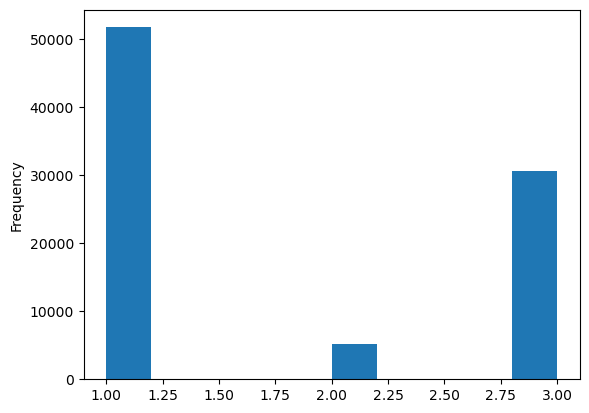

In [24]:
df_final.sample_type.plot(kind = "hist");